In [1]:
%pylab inline 

from nltk.corpus import stopwords
from nltk import PorterStemmer
import nltk
import ujson
import re
import time
import progressbar
import pandas as pd
import json
from nltk import word_tokenize
import numpy as np
import random
import string
from collections import OrderedDict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('stopwords') #download the latest stopwords
nltk.download("averaged_perceptron_tagger")
nltk.download("conll2000")

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gaura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gaura\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\gaura\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


True

Original parsing code

In [2]:
# import pandas as pd
# import gzip
# def parse(path):
#     g = gzip.open(path, 'rb')
#     for l in g:
#         yield eval(l)
        
# def getDF(path):
#     i = 0
#     df = {}
#     for d in parse(path):
#         df[i] = d
#         i += 1
#     return pd.DataFrame.from_dict(df, orient='index')

# # change this
# df = getDF('reviews_Office_Products_5.json.gz')

Custom parsing code

In [3]:

category_map = {
   # "Amazon_Instant_Video" : 0,
   # "Apps_for_Android" : 1,
   # "Automotive" : 2,
   # "Baby" : 3,
   # "Beauty" : 4,
   # "Books" : 5,
#     "CDs_and_Vinyl" : 6,
#     "Cell_Phones_and_Accessories" : 7,
#     "Clothing_Shoes_and_Jewelry" : 8,
#     "Digital_Music" : 9,
#    "Electronics" : 10
#     "Grocery_and_Gourmet_Food" : 11,
#     "Health_and_Personal_Care" : 12,
#     "Home_and_Kitchen" : 13,
#     "Kindle_Store" : 14,
#     "Movies_and_TV" : 15,
#     "Musical_Instruments" : 16,
     "Office_Products" : 17
#     "Patio_Lawn_and_Garden" : 18,
#     "Pet_Supplies" : 19,
#     "Sports_and_Outdoors" : 20,
#     "Tools_and_Home_Improvement" : 21,
#     "Toys_and_Games" : 22,
#     "Video_Games" : 23
}

col_names = ["reviewer_id", "asin", "summary","review_text", "overall", "category", "total_votes","upvotes","score",
             "good", "bad"]

def read_dataset():
    data =[]
    for category in category_map:
        fn = category + "_"+"5" + ".json"
        print("Reading category", category)
        with open(fn) as f:
            for line in f:
                d = json.loads(line)
                pf, tf = d["helpful"]
                if tf > 5 and len(d["reviewText"].split()) > 10:
                    score = int(pf) / int(tf)
                    row = [d["reviewerID"], 
                           d["asin"], 
                           d["summary"],
                           d["reviewText"],
                           d["overall"],
                           category_map[category],
                           int(tf),
                           int(pf),
                           (score),
                           int(score >= 0.80),
                           int(score <= 0.20)]
                    data.append(row)
                    
    return pd.DataFrame(data, columns=col_names)

df = read_dataset()

Reading category Office_Products


In [4]:
def text_richness(text):
    return len(set(text.split()))/len(text.split())

In [5]:
df['text_richness'] = df.review_text.apply(lambda x: text_richness(x))

In [6]:
df.corr()

,overall,category,total_votes,upvotes,score,good,bad,text_richness
overall,1.000000,NaN,0.021352,0.035153,0.304032,0.270249,-0.142294,-0.024252
category,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_votes,0.021352,NaN,1.000000,0.998658,0.137855,0.137207,-0.039529,-0.194919
upvotes,0.035153,NaN,0.998658,1.000000,0.163803,0.156334,-0.057351,-0.197798
score,0.304032,NaN,0.137855,0.163803,1.000000,0.816368,-0.602715,-0.188365
good,0.270249,NaN,0.137207,0.156334,0.816368,1.000000,-0.305710,-0.146793
bad,-0.142294,NaN,-0.039529,-0.057351,-0.602715,-0.305710,1.000000,0.141448
text_richness,-0.024252,NaN,-0.194919,-0.197798,-0.188365,-0.146793,0.141448,1.000000


Histogram of word counts

In [7]:
def word_count(text):
    return len([x for x in text.split()])

Wall time: 0 ns


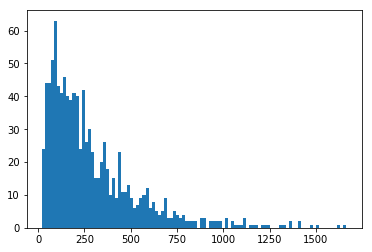

In [8]:
%time
cnt = map(word_count, df.query('score == 1').review_text.values)
hist(list(cnt), bins = 100);

Negative filtering logic: total upvotes less than half of the total votes

In [9]:
df_negative = df[(df.total_votes - df.upvotes)/df.total_votes > 0.5]

In [13]:
df_negative.review_text.values

array([ "Bought this product recently based on recommendations for an advanced math/ scientific calculator.  Apparently, TI has almost all the schools eating out of their hands by having classrooms make these calculators mandatory in many classes.I will say that the calculator features a lot and you can even purchase more applications to dowload at TI's Website.  However, the calculator is complicated to use, and you almost need a course to learn how to use it.  Furthermore, the functionality is poorly designed and if you press a wrong button the calculator will often freeze on you.At the high price for these TI calculators you would think that they would have gotten all the bugs out.  But let me assure you they are definitely there, and you would be better served to get a Casio or HP graphing calculator instead.",
       'Great bang for the buck.  Buy it, and I promise you will not be disappointed.',
       'This product is for real geeks only. I bought it as a souvenir and office dec

In [11]:
n = 0
sentences = nltk.sent_tokenize(df.review_text.values[n])
sentences = [nltk.word_tokenize(sent) for sent in sentences]
sentences = [nltk.pos_tag(sent) for sent in sentences]
grammar = "Praise: {}"
cp = nltk.RegexpParser(grammar)
result = cp.parse(sentences[1])
print(result)

# nltk.app.chunkparser()

(S
  I/PRP
  feel/VBP
  very/RB
  obliged/VBN
  to/TO
  share/NN
  my/PRP$
  views/NNS
  about/IN
  this/DT
  old/JJ
  workhorse/NN
  ,/,
  the/DT
  HP12C/NNP
  GOLD/NNP
  at/IN
  its/PRP$
  25th/CD
  anniversary/NN
  and/CC
  my/PRP$
  1Oth/CD
  year/NN
  as/IN
  a/DT
  satisfied/JJ
  ower/JJR
  user/NN
  and/CC
  fan/NN
  ./.)


In [98]:
n = 0
txt = nltk.Text(df.review_text.values[n].split())

# fd = nltk.FreqDist([w for w in txt if w.istitle()])
# fd.most_common()

nltk.pos_tag(txt)

[('WHY', 'WRB'),
 ('THIS', 'NNP'),
 ('BELATED', 'NNP'),
 ('REVIEW?', 'NNP'),
 ('I', 'PRP'),
 ('feel', 'VBP'),
 ('very', 'RB'),
 ('obliged', 'VBN'),
 ('to', 'TO'),
 ('share', 'NN'),
 ('my', 'PRP$'),
 ('views', 'NNS'),
 ('about', 'IN'),
 ('this', 'DT'),
 ('old', 'JJ'),
 ('workhorse,', 'VBZ'),
 ('the', 'DT'),
 ('HP12C', 'NNP'),
 ('GOLD', 'NNP'),
 ('at', 'IN'),
 ('its', 'PRP$'),
 ('25th', 'CD'),
 ('anniversary', 'NN'),
 ('and', 'CC'),
 ('my', 'PRP$'),
 ('1Oth', 'CD'),
 ('year', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('satisfied', 'JJ'),
 ('ower', 'JJR'),
 ('user', 'NN'),
 ('and', 'CC'),
 ('fan.', 'NN'),
 ('Especially', 'RB'),
 ('after', 'IN'),
 ('sharing', 'VBG'),
 ('my', 'PRP$'),
 ('frank', 'JJ'),
 ('views', 'NNS'),
 ('on', 'IN'),
 ('Amazon', 'NNP'),
 ('about', 'IN'),
 ('two', 'CD'),
 ('of', 'IN'),
 ('its', 'PRP$'),
 ('three', 'CD'),
 ('successors', 'NNS'),
 ('on', 'IN'),
 ('Amazon.com,', 'NNP'),
 ('burying', 'VBG'),
 ('the', 'DT'),
 ('HP12c', 'NNP'),
 ('Platinum', 'NNP'),
 ('(2004', 'VBD')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gaura\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [78]:
df.review_text.values[5]

"I didn't take math my senior year of high school and didn't know where my calculator was when I started college.  I bought this one because it was cheap, compared to the TI 83 that I wanted.  I used it for 2 years before it was damaged (my fault, not a product defect).I bought a cheap calculator to replace it and have been very disappointed. I plan on getting another calculator like these before my statistics class next semester."

In [55]:
nltk.FreqDist(df.review_text.values[0].lower().split()).hapaxes()

['belated',
 'review?',
 'feel',
 'obliged',
 'share',
 'workhorse,',
 '1oth',
 'satisfied',
 'ower',
 'user',
 'fan.',
 'sharing',
 'frank',
 'amazon',
 'amazon.com,',
 'burying',
 '(2004',
 '1st',
 'hp12cp)',
 'praising',
 'platiunum',
 'edition',
 '(2006',
 '3rd',
 'hp12cpae',
 'hp12cpa).to',
 'fans,',
 'including',
 'non-techkie',
 'nerd',
 'myself,',
 'fans.',
 'synonymous',
 'highest',
 'range',
 'offered',
 'calculators',
 'before',
 'first',
 'generation',
 'hits',
 'desktops',
 'users.to',
 'date',
 '(december',
 '2007),',
 'bearer',
 'none',
 '"golden',
 'boy"',
 'segment.the',
 'now',
 'matured',
 'continuing',
 'surviving',
 "'81",
 'longest',
 'ever.',
 'according',
 'almost',
 '15',
 'million',
 '12cs,',
 'cps',
 'was',
 'sold',
 ',it',
 '(and',
 'rpn)',
 'ever.as',
 'works',
 '1,',
 'factor',
 'sofware',
 'remaining',
 'unchanged',
 'been',
 'dethroned',
 'rivals',
 'even',
 'come',
 'go.even',
 'pc',
 'software',
 'versions',
 'being',
 'sold,',
 'remains',
 'truly',
 '

In [49]:
df.sort_values(by='score', ascending=0).review_text.values

array([ 'We have been using a previous version color laser multi-function,Brother MFC-9970CDW Color Laser All-in-One with Wireless Networking and Duplex, for several years now and have been fairly happy with it. This most recent upgrade offers a few welcome new features, but also retains some of the same flaws from the MFC-9970.First and foremost, this thing is huge, even slightly larger than the 9970, which was already a behemoth. This is about twice the size, both in width and height, as a standard laser printer and perhaps three times the weight. If you\'re using this in a home office scenario, as we are, make sure you have the room ... And help to lift it to wherever you plan to install it.Seriously, it\'s B-I-G check out the dimensions and measure before buying; this thing takes up more than half an average desktop.Other than physically moving the thing, install was simple. We\'re an all Apple household and I never use included printer software. I did all the unpacking--mostly a m

In [42]:
stemmer = PorterStemmer()
eng_stopwords =  stopwords.words('english') + ['thi',
'printer',
'print',
'paper',
'ink',
'ha',
'cartridg',
'thi printer',
'pen']

RE_PREPROCESS = r'\W+|\d+'  
#get rid of punctuation and make everything lowercase
processed_corpus = np.array( [ re.sub(RE_PREPROCESS, ' ', review).lower() for review in df_negative.review_text.values] )

vectorizer = CountVectorizer(analyzer = "word",
                            tokenizer = lambda x: [stemmer.stem(i) for i in x.split()], 
                            ngram_range = (0, 2),
                            stop_words = eng_stopwords,
                            strip_accents = "unicode",
                            min_df = 0.05,
                            max_df = 0.95)

In [43]:
%%time
bag_of_words = vectorizer.fit_transform( processed_corpus )
features = vectorizer.get_feature_names()

Wall time: 1min 6s


In [44]:
transformer = TfidfTransformer(norm = None,
                               sublinear_tf = True)

In [45]:
%%time
tfidf = transformer.fit_transform(bag_of_words)

Wall time: 34.1 ms


In [46]:
np_bag_of_words = bag_of_words.toarray()
word_count = np.sum(bag_of_words,axis=0)
np_word_count = np.asarray(word_count).ravel()
dict_word_counts = dict( zip(features, np_word_count) )
orddict_word_counts = OrderedDict( 
                                sorted(dict_word_counts.items(), key=lambda x: x[1], reverse=True), )
orddict_word_counts # helpful

OrderedDict([('use', 27820),
             ('wa', 16789),
             ('one', 16168),
             ('like', 11502),
             ('veri', 11457),
             ('work', 10818),
             ('need', 9183),
             ('get', 9175),
             ('color', 9150),
             ('would', 8188),
             ('time', 8122),
             ('scan', 8120),
             ('good', 8015),
             ('well', 7865),
             ('also', 7614),
             ('make', 7285),
             ('set', 7242),
             ('easi', 7180),
             ('qualiti', 7081),
             ('photo', 7018),
             ('onli', 6953),
             ('label', 6839),
             ('great', 6823),
             ('page', 6559),
             ('look', 6358),
             ('epson', 5600),
             ('much', 5475),
             ('realli', 5438),
             ('want', 5337),
             ('product', 5260),
             ('even', 5246),
             ('go', 5170),
             ('thing', 5129),
             ('scanner', 5071)

In [47]:
np_bag_of_words = tfidf.toarray()
word_count = np.sum(tfidf,axis=0)
np_word_count = np.asarray(word_count).ravel()
dict_word_counts = dict( zip(features, np_word_count) )
orddict_word_counts = OrderedDict( 
                                sorted(dict_word_counts.items(), key=lambda x: x[1], reverse=True), )
orddict_word_counts # helpful

OrderedDict([('use', 24625.420572576473),
             ('wa', 19854.991821272419),
             ('one', 19678.80778338086),
             ('like', 16868.287298962201),
             ('veri', 16749.289666707431),
             ('work', 16239.339034475153),
             ('need', 15017.029080692409),
             ('get', 14987.811122781193),
             ('color', 14585.235946544626),
             ('would', 14089.883378202163),
             ('time', 14073.893910304485),
             ('good', 13993.462576680433),
             ('well', 13871.624642322189),
             ('also', 13568.719346175765),
             ('make', 13323.599687496262),
             ('easi', 13189.247807226408),
             ('onli', 12926.407506309379),
             ('set', 12909.250080938167),
             ('qualiti', 12898.05664449142),
             ('great', 12857.454869344969),
             ('look', 12298.14207531699),
             ('scan', 11995.346487602055),
             ('page', 11766.6564959852),
             ('p

In [27]:
def create_topics(tfidf, features, N_TOPICS=3, N_TOP_WORDS=5,):
    """
    Given a matrix of features of text data generate topics
    
    Parameters
    -----------
    tfidf: scipy sparse matrix
        sparse matrix of text features
    N_TOPICS: int
        number of topics (default 10)
    N_TOP_WORDS: int
        number of top words to display in each topic (default 10)
        
    Returns
    -------
    ls_keywords: ls
        list of keywords for each topics
    doctopic: array
        numpy array with percentages of topic that fit each category
    N_TOPICS: int
        number of assumed topics
    N_TOP_WORDS: int
        Number of top words in a given topic. 
    """
    
    with progressbar.ProgressBar(max_value=progressbar.UnknownLength) as bar:
        i=0
        lda = LatentDirichletAllocation( n_components = N_TOPICS,
                                       learning_method='online') #create an object that will create 5 topics
        bar.update(i)
        i+=1
        doctopic = lda.fit_transform( tfidf )
        bar.update(i)
        i+=1
        
        ls_keywords = []
        for i,topic in enumerate(lda.components_):
            word_idx = np.argsort(topic)[::-1][:N_TOP_WORDS]  # reverse sort, take indices of N_TOP_WORDS
            keywords = ', '.join( features[i] for i in word_idx)
            ls_keywords.append(keywords)
#             from IPython.core.debugger import Tracer
#             Tracer()() #this one triggers the debugger
            print(i, keywords)
            bar.update(i)
            i+=1
            
    return ls_keywords, doctopic

In [50]:
ls_corpus_keywords, corpus_doctopic = create_topics(tfidf,
                                                    features,
                                                    N_TOPICS=5,
                                                    N_TOP_WORDS=10)

| 4 Elapsed Time: 0:01:29                                                      


0 wireless, network, instal, home, setup, machin, wa, laser, offic, easi
1 scan, photo, epson, scanner, document, softwar, canon, color, copi, x
2 label, binder, cover, plastic, use, sheet, hold, open, size, folder
3 tape, write, use, color, pencil, price, like, buy, good, pack
4 phone, wa, one, call, time, get, number, review, first, use


Bigram analysis

In [53]:
vectorizer_gram = CountVectorizer(analyzer = "word",
                            tokenizer = lambda x: [stemmer.stem(i) for i in x.split()], 
                            ngram_range = (2, 2),
                            stop_words = eng_stopwords,
                            strip_accents = "unicode",
                            min_df = 0.05,
                            max_df = 0.95)

bag_of_words_gram = vectorizer_gram.fit_transform( processed_corpus )
features_gram = vectorizer_gram.get_feature_names()

transformer = TfidfTransformer(norm = None,
                               sublinear_tf = True)

tfidf_gram = transformer.fit_transform(bag_of_words_gram)

ls_corpus_keywords_gram, corpus_doctopic_gram = create_topics(tfidf_gram,
                                                    features_gram,
                                                    N_TOPICS=5,
                                                    N_TOP_WORDS=15)

| 4 Elapsed Time: 0:00:08                                                      


0 work well, easi use, highli recommend, work great
1 easi use, highli recommend, work well, work great
2 work great, easi use, highli recommend, work well
3 easi use, highli recommend, work well, work great
4 highli recommend, easi use, work well, work great


In [52]:
np_bag_of_words = tfidf_gram.toarray()
word_count = np.sum(tfidf_gram,axis=0)
np_word_count = np.asarray(word_count).ravel()
dict_word_counts = dict( zip(features, np_word_count) )
orddict_word_counts = OrderedDict( 
                                sorted(dict_word_counts.items(), key=lambda x: x[1], reverse=True), )
orddict_word_counts # helpful

OrderedDict([('addit', 4303.4651440523739),
             ('abl', 3993.8210862205374),
             ('actual', 3543.2903512481134),
             ('add', 3169.8829619965177)])